In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler


In [2]:
pd.set_option('display.max_rows', None)


# Task 2

---

# Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

This is possible with the use of data and predictive models. The most important factor with a predictive model is the quality of the data you use to train the machine learning algorithms. For this task, you must manipulate and prepare the provided customer booking data so that you can build a high-quality predictive model.

With your predictive model, it is important to interpret the results in order to understand how “predictive” the data really was and whether we can feasibly use it to predict the target outcome (customers buying holidays). Therefore, you should evaluate the model's performance and output how each variable contributes to the predictive model's power.



## Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [3]:
df = pd.read_csv("data/customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [5]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [6]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [7]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5], dtype=int64)

In [8]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

For visuals & eda, I'm adding a second dataframe consisting only of instances in which `booking_complete == 1`, AKA purchasing customers.

In [9]:
# df1: df instances where booking_complete is 1
df1 = df[df["booking_complete"] == 1]
df1.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
82,1,Internet,RoundTrip,15,31,17,1,AKLKUL,Malaysia,0,0,0,8.83,1
86,1,Internet,RoundTrip,156,19,14,1,AKLKUL,Malaysia,1,0,0,8.83,1
94,1,Internet,RoundTrip,181,87,2,2,AKLKUL,Singapore,1,0,1,8.83,1
109,1,Mobile,RoundTrip,127,17,16,2,AKLKUL,Malaysia,1,0,1,8.83,1
122,1,Internet,RoundTrip,42,17,14,2,AKLKUL,Malaysia,0,0,0,8.83,1


In [10]:
df.num_passengers.value_counts()

1    31352
2    12804
3     2941
4     1784
5      561
6      289
7      114
8       89
9       66
Name: num_passengers, dtype: int64

A round-trip is a journey that returns to the city where it began, without additional stopovers. Thus, the ultimate destination is the originating city, with the same route used going and coming. A circle trip is like a round-trip except that the route on the return trip differs from the route on the outgoing trip.

[Definition & more info here.](https://www.thetravelinstitute.com/2022/11/15/air-travel-non-stops-direct-flights-round-trips-circle-trips/#:~:text=A%20round%2Dtrip%20is%20a,route%20on%20the%20outgoing%20trip.)

In [11]:
df.trip_type.value_counts()

RoundTrip     49497
OneWay          387
CircleTrip      116
Name: trip_type, dtype: int64

In [12]:
df.groupby("trip_type").count().booking_complete / len(df)


trip_type
CircleTrip    0.00232
OneWay        0.00774
RoundTrip     0.98994
Name: booking_complete, dtype: float64

In [13]:
pd.crosstab(df["trip_type"], df["booking_complete"], normalize="index")

booking_complete,0,1
trip_type,,
CircleTrip,0.956897,0.043103
OneWay,0.948320,0.051680
RoundTrip,0.849425,0.150575


Here is the 10 most popular searched-for routes:

In [14]:
df.route.value_counts().head(10)


AKLKUL    2680
PENTPE     924
MELSGN     842
ICNSIN     801
DMKKIX     744
ICNSYD     695
DMKPER     679
DPSICN     666
DMKOOL     655
MELPEN     649
Name: route, dtype: int64

Look at the 10 most popular routes booked:

In [15]:
pop_routes = df1.groupby("route").count().sort_values("booking_complete", ascending=False)["booking_complete"].head(10)
pop_routes

route
AKLKUL    567
PENTPE    401
DMKKIX    187
JHBKTM    164
MELPEN    137
ICNPEN    135
KTMPEN    118
CGKHND    105
HNDPEN     98
CGKKIX     96
Name: booking_complete, dtype: int64

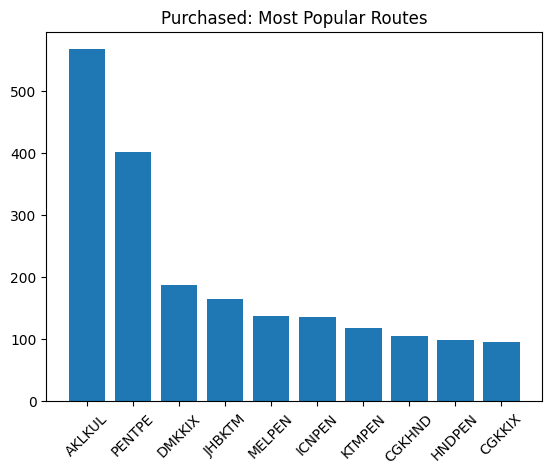

In [16]:
plt.bar(pop_routes.index, pop_routes)
plt.title("Purchased: Most Popular Routes")
plt.xticks(rotation=45)
plt.show()


Booking country of origin (for browsing):

In [17]:
df.booking_origin.value_counts().head(30)

Australia               17872
Malaysia                 7174
South Korea              4559
Japan                    3885
China                    3387
Indonesia                2369
Taiwan                   2077
Thailand                 2030
India                    1270
New Zealand              1074
Singapore                1044
United States             456
Vietnam                   388
Macau                     304
Hong Kong                 295
Philippines               266
United Kingdom            173
Brunei                    167
Cambodia                  132
(not set)                  84
Sri Lanka                  73
France                     59
Italy                      58
Canada                     57
Germany                    57
Myanmar (Burma)            51
Netherlands                46
Mauritius                  44
United Arab Emirates       42
Nepal                      40
Name: booking_origin, dtype: int64

Look at the most popular origin of booking customers:

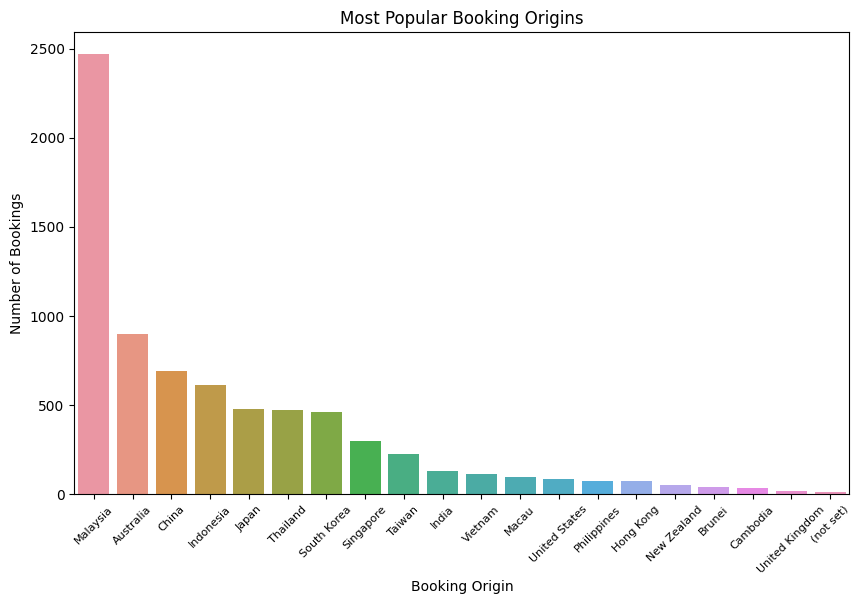

In [18]:
# visualize most popular booking_origin df1
# only include top 20 countries

plt.figure(figsize=(10, 6))
sns.countplot(data=df1, x="booking_origin", order=df1["booking_origin"].value_counts().iloc[:20].index)
plt.title("Most Popular Booking Origins")
plt.xlabel("Booking Origin")
plt.ylabel("Number of Bookings")
plt.xticks(rotation=45)
plt.xticks(fontsize=8)
plt.show()

Categorizing Length of Stay:

In [19]:
# add pd.cut to bin length_of_stay
df["stay_category"] = pd.cut(df["length_of_stay"], bins=5, labels=["very short", "short", "medium", "long", "very long"])
df.stay_category.value_counts()

very short    49416
short           468
medium          105
long              9
very long         2
Name: stay_category, dtype: int64

In [20]:
df.groupby("stay_category").count().booking_complete / len(df)

stay_category
very short    0.98832
short         0.00936
medium        0.00210
long          0.00018
very long     0.00004
Name: booking_complete, dtype: float64

In [21]:
pd.crosstab(df["stay_category"], df["booking_complete"], normalize="index")

booking_complete,0,1
stay_category,,
very short,0.850372,0.149628
short,0.852564,0.147436
medium,0.866667,0.133333
long,1.000000,0.000000
very long,0.500000,0.500000


Categorizing Flight Duration:

In [22]:
# add pd.cut to bin flight_duration
df["flight_duration_category"] = pd.cut(df["flight_duration"], bins=5, labels=["very short", "short", "medium", "long", "very long"])
df.flight_duration_category.value_counts()

very long     22329
very short    13279
medium         8319
long           3146
short          2927
Name: flight_duration_category, dtype: int64

In [23]:
df.booking_complete.value_counts()


0    42522
1     7478
Name: booking_complete, dtype: int64

In [24]:
df1.groupby("flight_day").mean()

C:\Users\abart\AppData\Local\Temp\ipykernel_12444\2928619992.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df1.groupby("flight_day").mean()


,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
flight_day,,,,,,,,,
1,1.622093,87.608804,20.969269,9.178571,0.749169,0.368771,0.471761,6.890233,1.0
2,1.654562,76.265722,19.241807,8.969885,0.738707,0.332152,0.442870,6.918760,1.0
3,1.654952,69.719649,18.957668,9.119010,0.752396,0.359425,0.464058,6.915264,1.0
4,1.567736,68.812834,20.007130,8.972371,0.753119,0.325312,0.454545,6.806996,1.0
5,1.657172,71.405900,20.239064,8.790437,0.750763,0.336724,0.460834,6.832126,1.0
6,1.701510,78.621370,18.775842,9.313589,0.743322,0.370499,0.435540,6.892381,1.0
7,1.717368,113.832794,18.862999,9.885653,0.724919,0.372168,0.475728,7.046785,1.0


In [25]:
pd.crosstab(df["flight_day"], df["booking_complete"], normalize="index")


booking_complete,0,1
flight_day,,
1,0.851395,0.148605
2,0.852861,0.147139
3,0.836852,0.163148
4,0.848869,0.151131
5,0.854607,0.145393
6,0.851858,0.148142
7,0.858560,0.141440


In [26]:
df.groupby("sales_channel").count().booking_complete / len(df)


sales_channel
Internet    0.88764
Mobile      0.11236
Name: booking_complete, dtype: float64

In [27]:
pd.crosstab(df["sales_channel"], df["booking_complete"], normalize="index")


booking_complete,0,1
sales_channel,,
Internet,0.845230,0.154770
Mobile,0.891598,0.108402


---

In [28]:
X= df.drop('booking_complete',axis=1)
y= df.booking_complete

In [29]:
# for each column in X factorize the values
for col in X.columns:
    X[col] = pd.factorize(X[col])[0]
    

In [30]:
X.dtypes


num_passengers              int64
sales_channel               int64
trip_type                   int64
purchase_lead               int64
length_of_stay              int64
flight_hour                 int64
flight_day                  int64
route                       int64
booking_origin              int64
wants_extra_baggage         int64
wants_preferred_seat        int64
wants_in_flight_meals       int64
flight_duration             int64
stay_category               int64
flight_duration_category    int64
dtype: object

In [31]:
mutual_info_classif(X,y)

array([0.0045292 , 0.0013821 , 0.        , 0.0016901 , 0.00465683,
       0.00319446, 0.00232078, 0.05339063, 0.04710124, 0.00373133,
       0.00423394, 0.00203127, 0.01686114, 0.00169745, 0.00725363])

In [32]:
# look at mutual info classif for each feature
mi = mutual_info_classif(X, y)
mi = pd.Series(mi, index=X.columns)
mi = mi.sort_values(ascending=False)
mi.head(10)

route                       0.051247
booking_origin              0.046450
flight_duration             0.015941
flight_duration_category    0.009360
length_of_stay              0.008812
num_passengers              0.005480
wants_in_flight_meals       0.004075
wants_preferred_seat        0.003977
wants_extra_baggage         0.002399
purchase_lead               0.001672
dtype: float64

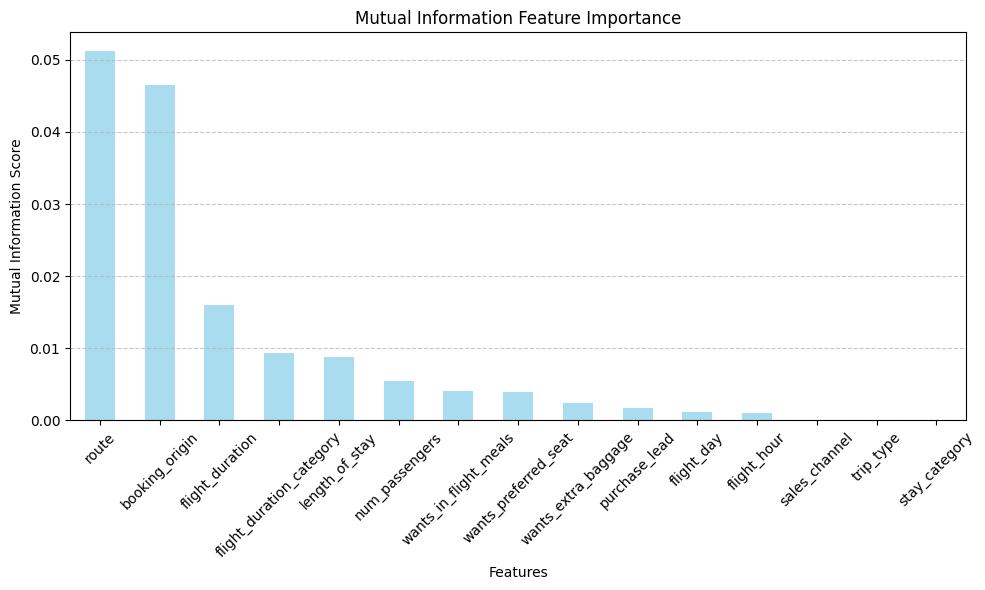

In [33]:
# visualize mutual info classif
plt.figure(figsize=(10, 6))  # Adjust figure size as needed

# Plotting with customized parameters
mi.plot.bar(color='skyblue', alpha=0.7)  # Custom color and transparency

plt.title("Mutual Information Feature Importance")
plt.xlabel("Features")
plt.ylabel("Mutual Information Score")
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add horizontal grid lines

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed

plt.tight_layout()  # Adjust layout for better spacing

plt.show()

In [34]:
# edit dataframe: add dummies
df_dummy = pd.get_dummies(df, drop_first=True)

df_dummy.head()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,...,booking_origin_Vanuatu,booking_origin_Vietnam,stay_category_short,stay_category_medium,stay_category_long,stay_category_very long,flight_duration_category_short,flight_duration_category_medium,flight_duration_category_long,flight_duration_category_very long
0,2,262,19,7,6,1,0,0,5.52,0,...,0,0,0,0,0,0,0,0,0,0
1,1,112,20,3,6,0,0,0,5.52,0,...,0,0,0,0,0,0,0,0,0,0
2,2,243,22,17,3,1,1,0,5.52,0,...,0,0,0,0,0,0,0,0,0,0
3,1,96,31,4,6,0,0,1,5.52,0,...,0,0,0,0,0,0,0,0,0,0
4,2,68,22,15,3,1,0,1,5.52,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
def train_test(X,y):
  train_full_X, val_X, train_full_y, val_y = train_test_split(X, y,test_size=0.2,random_state = 0)
  train_X, test_X, train_y, test_y = train_test_split(train_full_X, train_full_y,test_size=0.2,random_state = 0)
  return train_X, test_X, train_y, test_y, val_X, val_y

In [36]:
# Method 1: Random Forest Classification
X= df_dummy.drop('booking_complete',axis=1)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
y= df_dummy.booking_complete
train_X, test_X, train_y, test_y, val_X, val_y = train_test(X,y)

clf = RandomForestClassifier()
clf.fit(train_X, train_y)

y_pred = clf.predict(test_X)
accuracy_score(test_y, y_pred)

0.84625

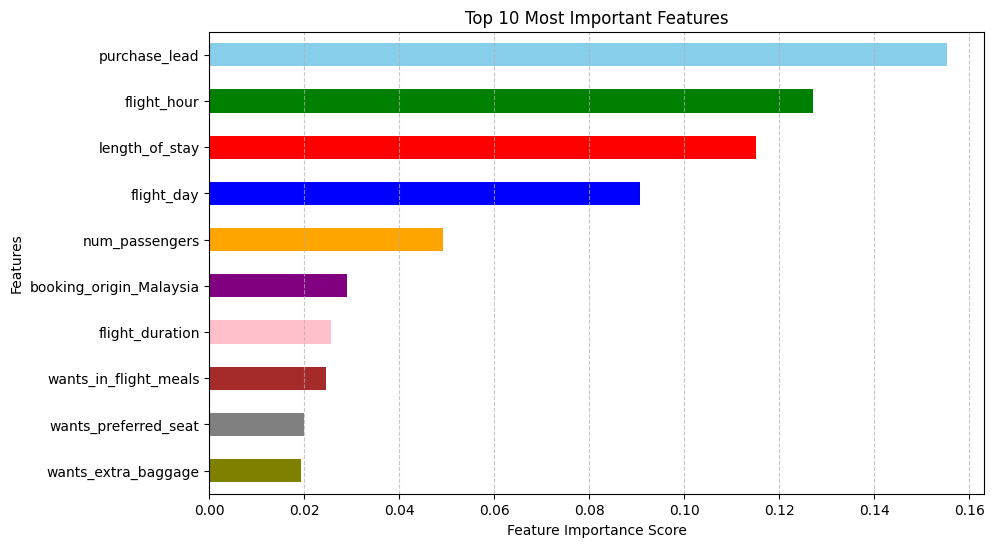

In [38]:
# visualize feaeture importance
feat_importances = pd.Series(clf.feature_importances_, index=df_dummy.drop('booking_complete',axis=1).columns)
feat_importances = feat_importances.nlargest(10)
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
feat_importances.plot(kind='barh', color=['skyblue', 'green', 'red', 'blue', 'orange', 'purple', 'pink', 'brown', 'gray', 'olive'])
plt.gca().invert_yaxis()  # Invert y-axis to have most important feature at the top
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Top 10 Most Important Features')
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Add grid lines

plt.show()


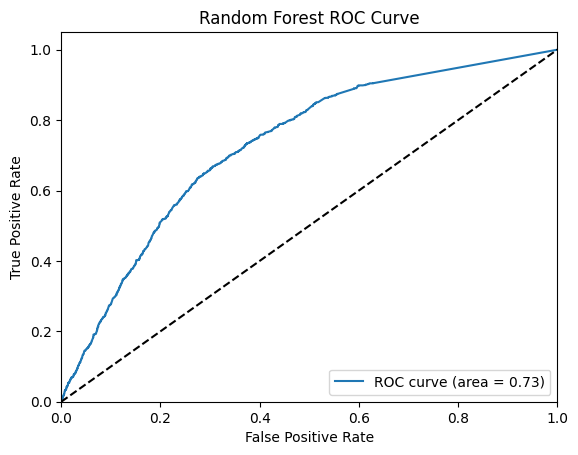

In [50]:
# roc curve
y_pred_prob = clf.predict_proba(test_X)[:,1]
fpr, tpr, thresholds = roc_curve(test_y, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [40]:
# classification report
print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.97      0.91      6786
           1       0.48      0.13      0.20      1214

    accuracy                           0.85      8000
   macro avg       0.67      0.55      0.56      8000
weighted avg       0.80      0.85      0.81      8000



In [42]:
# Method 2: Random Forest Classification Using the Following Features:
# route, booking_origin, flight_duration, and length_of_stay
X= df[['route', 'booking_origin', 'flight_duration', 'length_of_stay']]

X = pd.get_dummies(X, drop_first=True)

scaler = MinMaxScaler()
X = scaler.fit_transform(X)
y= df.booking_complete
train_X, test_X, train_y, test_y, val_X, val_y = train_test(X,y)

clf = RandomForestClassifier()
clf.fit(train_X, train_y)

y_pred = clf.predict(test_X)
accuracy_score(test_y, y_pred)

0.82375

In [43]:
print(classification_report(test_y, y_pred))


              precision    recall  f1-score   support

           0       0.86      0.94      0.90      6786
           1       0.34      0.16      0.22      1214

    accuracy                           0.82      8000
   macro avg       0.60      0.55      0.56      8000
weighted avg       0.78      0.82      0.80      8000



In [46]:
# Method 3: Binary Regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logreg = LogisticRegression(class_weight="balanced")
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

accuracy_score(y_test, y_pred)

c:\Users\abart\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6918

In [47]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.68      0.79      8520
           1       0.29      0.76      0.42      1480

    accuracy                           0.69     10000
   macro avg       0.62      0.72      0.61     10000
weighted avg       0.85      0.69      0.74     10000



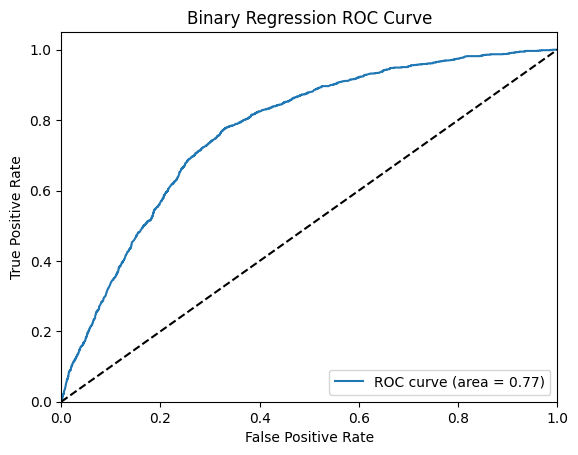

In [51]:
# roc curve
y_pred_prob = logreg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Binary Regression ROC Curve')
plt.legend(loc="lower right")
plt.show()